# Predicting Donor's Choose

1. What is the primary metric you care about in this task?  Be sure to clearly state the question about why this is the case.
1. Is the column `teacher_number_of_previously_posted_projects` a good predictor for the approval of the project? Use both a `KNearestNeighbors` and `LogisticRegression` model. Which model performs better?  Can you select the best parameters for each?  The best penalty for `LogisticRegression`?  Form a pipeline that includes a scaling transformation?  Compare this to a `DummyClassifier`?
2. What are the top 8 states in terms of raw number approved? The lowest?  Show me with a nice barplot.
3. Are these states different from the number of proportion of applications approved by state?  Show me.
4. Does your model improve with the inclusion of the `teacher_prefix` column in a `LogisticRegression` model?
5. What is your best parameter for the training set with these inputs?
6. Construct a feature that is simply `STEM`, which is 1 if a scientific discipline is a part of the `subject_subcategory` column, or 0 if not.  Did your model improve?
7. What if you include the `project_grade_category` column?  Is your model improved?
8. What if your client only cares about what's happening in New York.  Is there a difference in the performance of a `LogisticRegression` model? `KNearestNeighbors`?


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# set chart style
sns.set(style='ticks')
%matplotlib inline

In [2]:
train = pd.read_csv('data/donorschoose_train.csv', index_col = 'id')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182080 entries, p036502 to p190772
Data columns (total 15 columns):
teacher_id                                      182080 non-null object
teacher_prefix                                  182076 non-null object
school_state                                    182080 non-null object
project_submitted_datetime                      182080 non-null object
project_grade_category                          182080 non-null object
project_subject_categories                      182080 non-null object
project_subject_subcategories                   182080 non-null object
project_title                                   182080 non-null object
project_essay_1                                 182080 non-null object
project_essay_2                                 182080 non-null object
project_essay_3                                 6374 non-null object
project_essay_4                                 6374 non-null object
project_resource_summary               

In [4]:
train.head()

,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
id,,,,,,,,,,,,,,,
p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1
p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0
p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1
p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0
p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1


### wrangle data

In [5]:
train.teacher_prefix.value_counts()

Mrs.       95405
Ms.        65066
Mr.        17667
Teacher     3912
Dr.           26
Name: teacher_prefix, dtype: int64

In [6]:
# create new gender variable

gender_map = {
    "Mrs.": "W",
    "Ms.": "W",
    "Mr.": "M",
    "Teacher": "Unknown",
    "Dr.": "Unknown"
}

train['gender'] = train.teacher_prefix.map(gender_map)

In [7]:
train.gender.value_counts()

W          160471
M           17667
Unknown      3938
Name: gender, dtype: int64

In [8]:
# create new variables for essay length

## can also do train['wc_1'] = train.project_essay_1.apply(len)
train['wc_1'] = train.project_essay_1.apply(lambda essay: len(essay) if isinstance(essay,str) else 0)
train['wc_2'] = train.project_essay_2.apply(lambda essay: len(essay) if isinstance(essay,str) else 0)
train['wc_3'] = train.project_essay_3.apply(lambda essay: len(essay) if isinstance(essay,str) else 0)
train['wc_4'] = train.project_essay_4.apply(lambda essay: len(essay) if isinstance(essay,str) else 0)

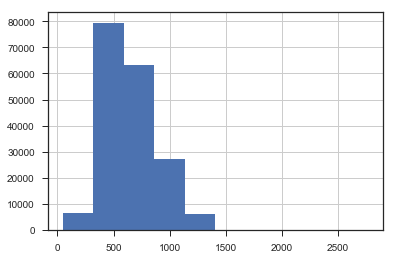

In [9]:
train.wc_1.hist()

In [10]:
# create new variable for average essay length

train['avg_wc'] = (train['wc_1'] + train['wc_2'] + train['wc_3'] + train['wc_4'])/4

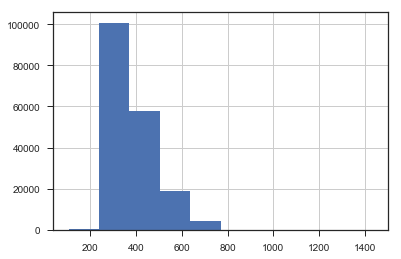

In [11]:
train.avg_wc.hist()

In [12]:
train.project_submitted_datetime = pd.to_datetime(train.project_submitted_datetime,format='%Y-%m-%d %H:%M:%S')

In [13]:
train['year'] = train.project_submitted_datetime.dt.year

In [14]:
train.year.value_counts()

2016    131473
2017     50607
Name: year, dtype: int64

### feed in all the variables

In [15]:
X = train[['school_state','year','project_grade_category','project_subject_categories',
           'project_subject_subcategories','teacher_number_of_previously_posted_projects',
           'gender','wc_1','wc_2','wc_3','wc_4','avg_wc']]

X = pd.get_dummies(X,columns=['school_state','project_grade_category','project_subject_categories',
                              'project_subject_subcategories','gender'],drop_first=True)

X = X[:1000]

In [16]:
y = train.project_is_approved[:1000]

X_train, X_test, y_train, y_test = train_test_split(X,y)

clf = LogisticRegression()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("accuracy score:",accuracy_score(y_test,y_pred))

accuracy score: 0.848


In [17]:
dummy = DummyClassifier()
dummy.fit(X_train,y_train)
y_dummy = dummy.predict(X_test)

print("accuracy score:",accuracy_score(y_test,y_dummy))

accuracy score: 0.74


### scale

In [18]:
pipe = make_pipeline(StandardScaler(),LogisticRegression())

In [19]:
params = {'logisticregression__C': [0.1, 1, 5, 10, 100, 1000], 'logisticregression__penalty': ['l1','l2']}

In [20]:
grid = GridSearchCV(pipe,param_grid=params, cv=5)

In [21]:
grid.fit(X_train,y_train)

best = grid.best_estimator_

best.fit(X_train,y_train)
y_best = best.predict(X_test)

print("accuracy score:",accuracy_score(y_test,y_best))

accuracy score: 0.84


In [22]:
grid.best_params_

{'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1'}